# Toxicity Classification

1. #### Problem Defination 

        When person sees negative comments about themselves. They feel suffocated, deppressesd, anxiety hit them. so, to solve this problem and encourage people to give positive comments, me and my team is creating the toxicity classifier which can classifies negative, positive words and comments. 

2. #### Importing necessary Libraries

In [1]:
import numpy as np
import pandas as pd 
import os 
from bs4 import BeautifulSoup
import re, string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pylab as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
from collections import Counter
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
import html
import unicodedata
print(os.getcwd())

c:\Users\Asus\Documents\zenscroll_app


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


3. #### finding and reading the datas

In [2]:
train = pd.read_csv("dataset/train/train.csv", encoding="utf-8")
test = pd.read_csv("dataset/test/test.csv",  encoding="utf-8")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

4. #### Data Preprocessing (Text Cleaning)

In [4]:
def clean_text(text):

    # removing stop words from text s
    stop = set(stopwords.words('english'))
    # updating the text with punctuation to make new line. 
    stop.update(list(string.punctuation))

    # Remove unwanted html characters
    remove_html_chars = re.compile(r'  +')
    replace_char = text.lower().replace('#39;', "'")\
                .replace('amp;', '&').replace('#146;', "'")\
                .replace('nbsp;', ' ').replace('#36;', '$')\
                .replace('\\n', "\n").replace('quot;', "'")\
                .replace('<br />', "\n").replace('\\"', '"')\
                .replace('<unk>', 'u_n').replace(' @.@ ', '.')\
                .replace(' @-@ ', '-').replace('\\', ' \\ ')
    text = remove_html_chars.sub(' ', html.unescape(replace_char))
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # remove between square characters 
    text = re.sub('\[[^]]*\]', '', text)

    # remove URLs 
    text = re.sub(r'https://\S+', '', text)

    # remove tags 
    text = text.replace("@", "")

    # remove hashtags
    text = text.replace("#", '')

    # remove all non alphaetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # replace underscores
    text = text.replace("_", " ")

    # replace - 
    text = text.replace('-', ' ')

    tokens = nltk.word_tokenize(text)

    # remove stopwords 
    stopped_words = [word for word in tokens if word not in stop]

    # converting the words to base by removing the suffixes
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stopped_words]
    clean_text = " ".join(lemmatized_words)

    return clean_text 

In [5]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [6]:
train.isna().sum()

id                                           0
target                                       0
comment_text                                 3
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

In [7]:
train.shape

(1804874, 45)

In [8]:
zen_data = train.copy()
zen_data['threat'] = np.where(zen_data['threat'] >= .25, 1, 0)
zen_data['severe_toxicity'] = np.where(zen_data['severe_toxicity'] >= .25, 1, 0)
zen_data['insult'] = np.where(zen_data['insult'] >= .25, 1, 0)
zen_data['obscene'] = np.where(zen_data['obscene'] >= .25, 1, 0)
zen_data['identity_attack'] = np.where(zen_data['identity_attack'] >= .25, 1, 0)

In [9]:
possible_labels = ["comment_text","target","severe_toxicity", "obscene", "threat", "insult", "identity_attack"]
dataset = zen_data[possible_labels]
dataset = dataset[(dataset['target']>=.5)]
dataset.head()

,comment_text,target,severe_toxicity,obscene,threat,insult,identity_attack
4,haha you guys are a bunch of losers.,0.893617,0,0,0,1,0
5,ur a sh*tty comment.,0.666667,0,1,0,1,0
13,It's ridiculous that these guys are being call...,0.600000,0,0,0,1,0
14,This story gets more ridiculous by the hour! A...,0.500000,0,0,0,1,0
19,"Angry trolls, misogynists and Racists"", oh my....",0.500000,0,0,0,1,0


In [10]:
dataset.isna().sum()
dataset.duplicated().sum()
dataset.drop_duplicates(keep='first')

,comment_text,target,severe_toxicity,obscene,threat,insult,identity_attack
4,haha you guys are a bunch of losers.,0.893617,0,0,0,1,0
5,ur a sh*tty comment.,0.666667,0,1,0,1,0
13,It's ridiculous that these guys are being call...,0.600000,0,0,0,1,0
14,This story gets more ridiculous by the hour! A...,0.500000,0,0,0,1,0
19,"Angry trolls, misogynists and Racists"", oh my....",0.500000,0,0,0,1,0
...,...,...,...,...,...,...,...
1804825,Who is the jerk in the last row between the C ...,0.833333,0,0,0,1,0
1804838,Nobody really cares that she supports the scie...,0.700000,0,0,0,1,0
1804856,Believing in God or not believing in God are p...,0.500000,0,0,0,1,1
1804857,"I take your point, but I think you're shooting...",0.700000,0,1,0,1,0


In [11]:
dataset['clean_text'] = dataset['comment_text'].apply(clean_text)
dataset.head()

,comment_text,target,severe_toxicity,obscene,threat,insult,identity_attack,clean_text
4,haha you guys are a bunch of losers.,0.893617,0,0,0,1,0,haha guy bunch loser
5,ur a sh*tty comment.,0.666667,0,1,0,1,0,ur shtty comment
13,It's ridiculous that these guys are being call...,0.600000,0,0,0,1,0,ridiculous guy called protester armed threat v...
14,This story gets more ridiculous by the hour! A...,0.500000,0,0,0,1,0,story get ridiculous hour love people sending ...
19,"Angry trolls, misogynists and Racists"", oh my....",0.500000,0,0,0,1,0,angry troll misogynist racist oh doesnt take i...


5. #### Exploratory Data Analysis (EDA)
    1. #### Word Cloud Representation of Negative Words (identity attack)

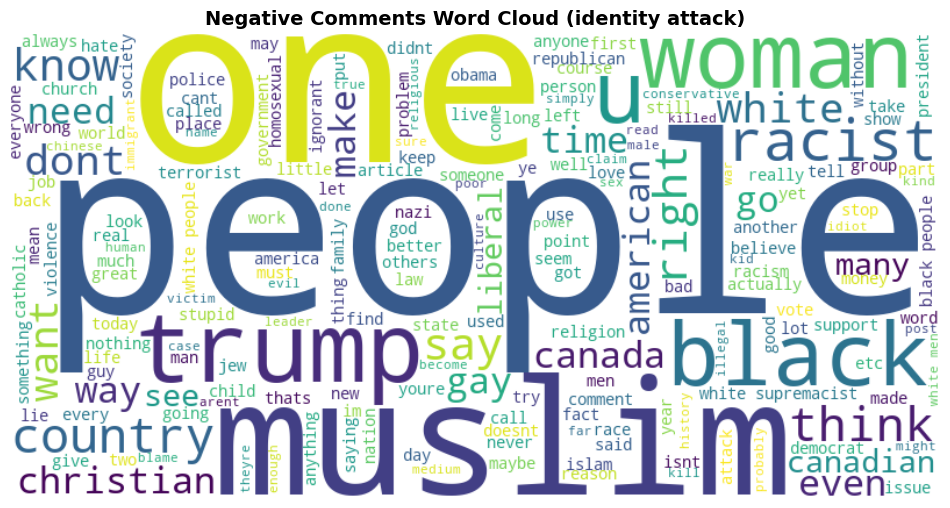

In [12]:
clean_text = dataset.iloc[:5000, 7].values
cloud_words = []
for sent in clean_text:
    cloud_words.append(sent)
cloud_words = ' '.join(cloud_words)

wc = WordCloud(width=800, height=400, background_color='white')
wordcloud = wc.generate(dataset[dataset['identity_attack'] == 1]['clean_text'].str.cat(sep=" "))

plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Comments Word Cloud (identity attack)', fontsize=14, fontweight='bold')
plt.show()

2. #### Word Cloud Representation of Negative Words (Obscene)

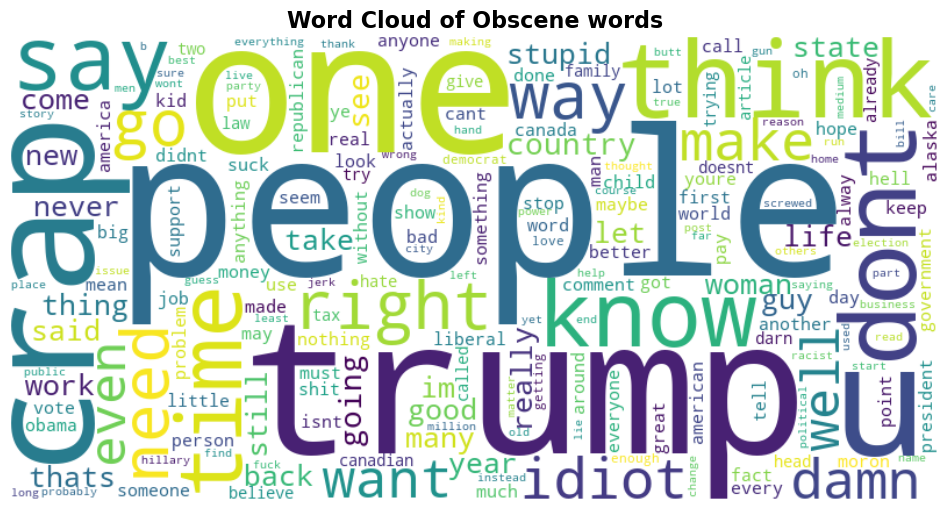

In [13]:
wordcloud = wc.generate(dataset[dataset['obscene'] == 1]['clean_text'].str.cat(sep=' '))

plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Obscene words", fontsize=16, fontweight='bold')
plt.show()

#### Count Characters, Words, Sentences in the Corpus 

In [14]:
def count_characters(text):
    icount = 0
    for word in text:
        if word.isdigit():
            continue
        icount = icount + 1
    return icount

dataset['num_characters'] = dataset['clean_text'].apply(count_characters)
dataset['num_words'] = dataset['clean_text'].apply(lambda x : len(nltk.word_tokenize(x)))
dataset['num_sentences'] = dataset['clean_text'].apply(lambda x : len(nltk.sent_tokenize(x)))

#### Description and Statistics of the Counted Characters 

In [15]:
dataset[['num_characters', 'num_sentences', 'num_words']].describe()

,num_characters,num_sentences,num_words
count,144334.000000,144334.000000,144334.000000
mean,173.531774,0.999979,25.275327
std,154.863004,0.004559,21.977364
min,0.000000,0.000000,0.000000
25%,61.000000,1.000000,9.000000
50%,122.000000,1.000000,18.000000
75%,232.000000,1.000000,34.000000
max,953.000000,1.000000,305.000000


#### Descriptions and Statictics of Obscene Word (abusive words, lust, sex words)

In [16]:

dataset[dataset['obscene'] == 1][['num_characters', 'num_sentences', 'num_words']].describe()

,num_characters,num_sentences,num_words
count,18952.000000,18952.0,18952.000000
mean,182.149430,1.0,27.323185
std,162.076762,0.0,23.484097
min,2.000000,1.0,1.000000
25%,60.000000,1.0,10.000000
50%,128.000000,1.0,19.000000
75%,253.000000,1.0,38.000000
max,780.000000,1.0,109.000000


#### Descriptions and Statictics of Severe Toxicitiy Column 

In [17]:
# severe toxicity 
dataset[dataset['severe_toxicity'] == 1][['num_characters', 'num_sentences', 'num_words']].describe()

,num_characters,num_sentences,num_words
count,559.000000,559.0,559.000000
mean,182.747764,1.0,27.032200
std,172.926443,0.0,24.709401
min,4.000000,1.0,1.000000
25%,49.000000,1.0,8.000000
50%,112.000000,1.0,18.000000
75%,266.500000,1.0,39.000000
max,751.000000,1.0,103.000000


#### Descriptions and Statictics of Threat Column 

In [18]:
dataset[dataset['threat'] == 1][['num_characters', 'num_sentences', 'num_words']].describe()

,num_characters,num_sentences,num_words
count,8864.000000,8864.0,8864.000000
mean,126.419562,1.0,19.220329
std,128.900495,0.0,18.733409
min,3.000000,1.0,1.000000
25%,43.000000,1.0,7.000000
50%,82.000000,1.0,13.000000
75%,159.000000,1.0,24.000000
max,792.000000,1.0,118.000000


#### Descriptions and Statictics of Insult Column 

In [19]:
dataset[dataset['insult'] == 1][['num_characters', 'num_sentences', 'num_words']].describe()

,num_characters,num_sentences,num_words
count,130549.000000,130549.000000,130549.000000
mean,176.717118,0.999977,25.713180
std,155.807511,0.004794,22.110524
min,0.000000,0.000000,0.000000
25%,63.000000,1.000000,10.000000
50%,125.000000,1.000000,18.000000
75%,237.000000,1.000000,34.000000
max,953.000000,1.000000,305.000000


#### Descriptions and Statictics of Identity Attack Column

In [20]:
dataset[dataset['identity_attack'] == 1][['num_characters', 'num_sentences', 'num_words']].describe()

,num_characters,num_sentences,num_words
count,25151.000000,25151.0,25151.000000
mean,202.716512,1.0,29.079202
std,167.181575,0.0,23.549527
min,3.000000,1.0,1.000000
25%,77.000000,1.0,11.000000
50%,147.000000,1.0,21.000000
75%,279.000000,1.0,40.000000
max,953.000000,1.0,305.000000


#### distirbutions of number of characters by the obscene 

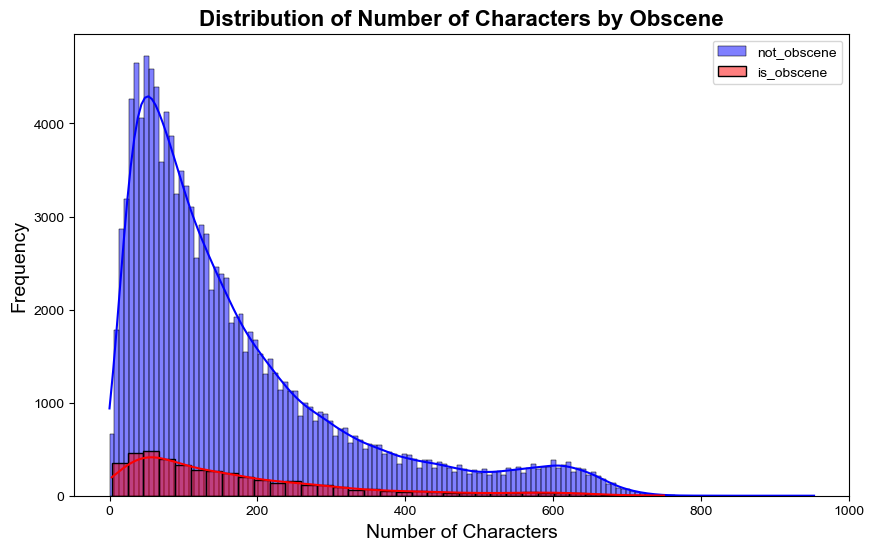

In [21]:
# Create a figure and set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram for obscene = 0 in blue
sns.histplot(dataset[dataset['obscene'] == 0]['num_characters'], color='blue', label='not_obscene', kde=True)

# Plot the histogram for obscene = 1 in red
sns.histplot(dataset[dataset['target'] == 1]['num_characters'], color='red', label='is_obscene', kde=True)

# Add labels and a title
plt.xlabel('Number of Characters', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Number of Characters by Obscene', fontsize=16, fontweight='bold')

# Add a legend
plt.legend()

# Customize the appearance of the plot
sns.set(style='darkgrid')

# Show the plot
plt.show()


#### distirbutions of number of characters by the insult

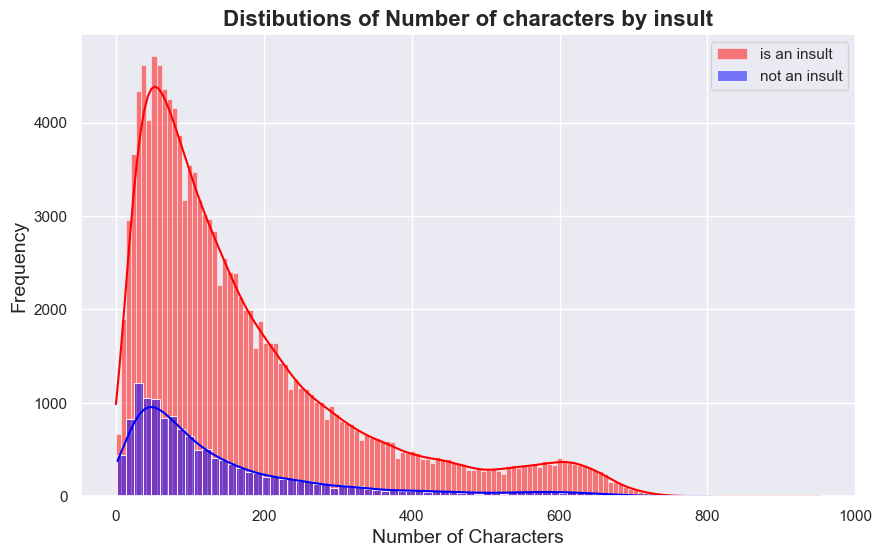

In [22]:
# distributions of number of characters by insult
plt.figure(figsize=(10, 6))

# plotting the histogram when insult is 1 
sns.histplot(dataset[dataset['insult'] == 1]['num_characters'], color='red', label='is an insult', kde=True)

# ploting the histogram when insult is 0
sns.histplot(dataset[dataset['insult'] == 0]['num_characters'],color='blue', label='not an insult', kde=True)

# add labels and title 
plt.title('Distibutions of Number of characters by insult', fontsize=16, fontweight='bold')
plt.xlabel('Number of Characters', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# adding legend
plt.legend()

sns.set(style='darkgrid')

plt.show()

#### correlation

In [23]:
dataset[['target', 'num_characters', 'num_words', 'num_sentences']].corr()

,target,num_characters,num_words,num_sentences
target,1.000000,-0.187983,-0.183039,-0.000651
num_characters,-0.187983,1.000000,0.992075,0.005109
num_words,-0.183039,0.992075,1.000000,0.005243
num_sentences,-0.000651,0.005109,0.005243,1.000000


#### Correlation Heatmap for target, num_characters, num_words and num_sentences

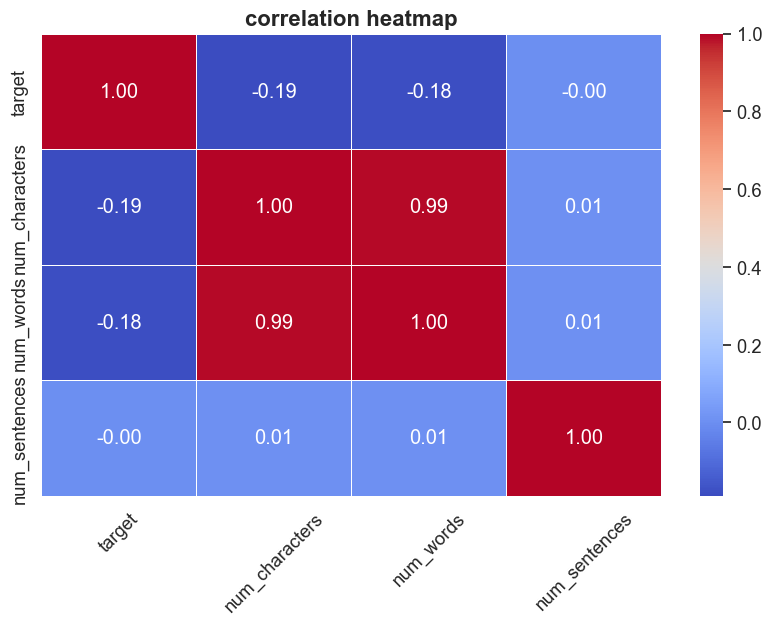

In [24]:
# creating the correlation matrix 
correlation_matrix = dataset[['target', 'num_characters', 'num_words', 'num_sentences']].corr()

# create a heatmap with custom styling
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

# set a title for the heatmap
plt.title('correlation heatmap', fontsize=16, fontweight='bold')

plt.xticks(rotation=45)
plt.show()

#### Showing Most 30 Negative Words in Corpus

C:\Users\Asus\AppData\Local\Temp\ipykernel_2716\77700022.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filter_df, x=filter_df[0], y=filter_df[1], palette='bright')


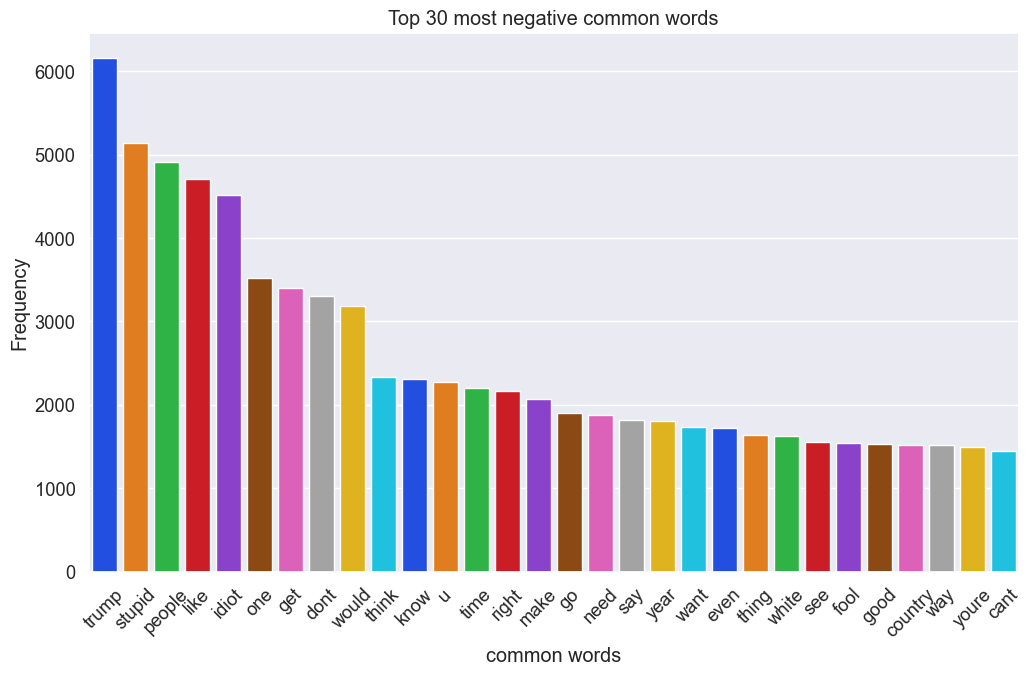

In [25]:
words_count = []
for sentence in dataset[dataset['target'] >= 0.8]['clean_text'].tolist():
    for word in sentence.split():
        words_count.append(word)

# -
plt.figure(figsize=(12, 7))
filter_df = pd.DataFrame(Counter(words_count).most_common(30))
sns.barplot(data=filter_df, x=filter_df[0], y=filter_df[1], palette='bright')
plt.title('Top 30 most negative common words')
plt.xlabel('common words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

#### Showing 30 Most Positive Words in Corpus

C:\Users\Asus\AppData\Local\Temp\ipykernel_2716\2105607609.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filter_df, x=filter_df[0], y=filter_df[1], palette='bright')


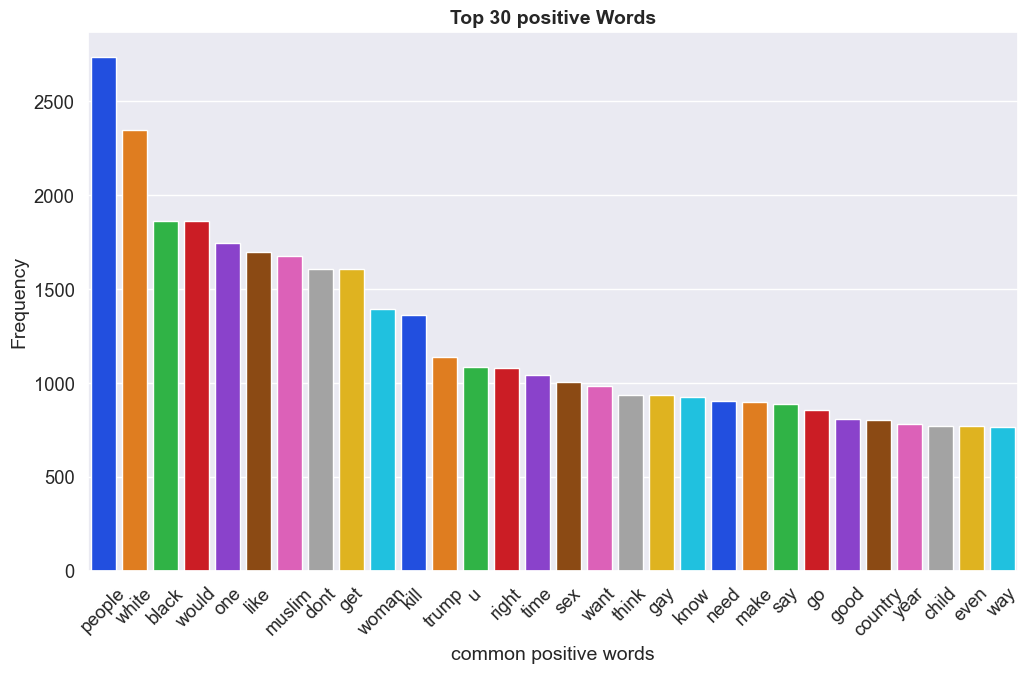

In [26]:
words_count = []
for sentence in dataset[dataset['insult'] != 1]['clean_text'].tolist():
    for word in sentence.split():
        words_count.append(word)


# final positive words (30)
plt.figure(figsize=(12, 7))
filter_df = pd.DataFrame(Counter(words_count).most_common(30))
sns.barplot(data=filter_df, x=filter_df[0], y=filter_df[1], palette='bright')
plt.title('Top 30 positive Words', fontsize=14, fontweight='bold')
plt.xlabel("common positive words", fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.show()